<a href="https://colab.research.google.com/github/antoninodimaggio/PyTorch-Adversarial-Examples/blob/master/Adversarial_Attack_On_CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adversarial Attack On CIFAR-10
* An adversarial example is when you mess up an image in order to fool a Convolutional Neural Network (CNN) into classifying an image into a different class.
* Research into how to prevent adversarial attacks is a very hot topic since the use of CNNs in production becomes more and more common everyday.
* This notebook focuses on an attack method known as the HopSkipJumpAttack. This attack can produce images that do not differ in appearance from the original yet will be classified as the wrong label.
*First we have to train a fairly robust CIFAR-10 classifier using PyTorch.


In [0]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms

In [0]:
class RobustCifar(nn.Module):


    def __init__(self):
        super(RobustCifar, self).__init__()

        self.conv_layer = nn.Sequential(  
            # block 1
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ELU(inplace=True),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ELU(inplace=True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.Dropout2d(p=0.2),
            # block 2
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ELU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ELU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.Dropout2d(p=0.3),
            # block 3
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ELU(inplace=True),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ELU(inplace=True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            nn.Dropout2d(p=0.4)
        )

        self.fc_layer = nn.Sequential(  
            nn.Linear(2048, 10),
            nn.Softmax(dim=1)
        )


    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)
        return x


def test():
    model = RobustCifar()
    x = torch.zeros(1,3,32,32)
    y = model(x)
    print(y)
# test()

In [0]:
# data augmentation for training
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])

test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])


train_set = torchvision.datasets.CIFAR10(root='./data/downloads', train=True,
                                        download=True, transform=train_transform)


test_set = torchvision.datasets.CIFAR10(root='./data/downloads', train=False,
                                       download=True, transform=test_transform)

test_set, validation_set = torch.utils.data.random_split(test_set, [5000, 5000])

# 50,000 training samples
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64,
                                          shuffle=True, num_workers=2,
                                          pin_memory=True)

# 5,000 validation samples
validation_loader = torch.utils.data.DataLoader(test_set, batch_size=64,
                                         shuffle=True, num_workers=2,
                                         pin_memory=True)

# 5,000 test samples
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1,
                                         shuffle=True, num_workers=2,
                                         pin_memory=True)


Extracting ./data/downloads/cifar-10-python.tar.gz to ./data/downloads
Files already downloaded and verified


In [0]:
# would not want to train this on a cpu
device = torch.device('cuda')
model = RobustCifar().to(device)
criterion = nn.CrossEntropyLoss()
"""
# ~ 81% 125 epochs
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.000001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[75, 100], gamma=0.5)
"""
# ~ 85% 120 epochs
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[75, 100], gamma=0.5)


num_epochs = 120
print('Start training ...')
for epoch in range(num_epochs):
  training_loss = 0.0
  validation_loss = 0.0
  model.train()
  for batch, (inputs, labels) in enumerate(train_loader, 0):
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    training_loss += loss.item()
  print('Training --> Epoch: %d, Loss: %1.8f LR: %1.8f' % (epoch+1, training_loss/len(train_loader), optimizer.param_groups[0]['lr']))
  scheduler.step()
  model.eval()
  for batch, (inputs, labels) in enumerate(validation_loader, 0):
    inputs, labels = inputs.to(device), labels.to(device)
    with torch.no_grad():
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      validation_loss += loss.item()
  print('Validation --> Epoch: %d, Loss: %1.8f' % (epoch+1, validation_loss/len(validation_loader)))
print('Done training!')

Start training ...
Training --> Epoch: 1, Loss: 2.11311411 LR: 0.00100000
Validation --> Epoch: 1, Loss: 2.06976370
Training --> Epoch: 2, Loss: 2.05368709 LR: 0.00100000
Validation --> Epoch: 2, Loss: 2.01400391
Training --> Epoch: 3, Loss: 2.01073951 LR: 0.00100000
Validation --> Epoch: 3, Loss: 1.94448510
Training --> Epoch: 4, Loss: 1.97341613 LR: 0.00100000
Validation --> Epoch: 4, Loss: 1.89129612
Training --> Epoch: 5, Loss: 1.94646561 LR: 0.00100000
Validation --> Epoch: 5, Loss: 1.86945141
Training --> Epoch: 6, Loss: 1.93035220 LR: 0.00100000
Validation --> Epoch: 6, Loss: 1.88402562
Training --> Epoch: 7, Loss: 1.91747389 LR: 0.00100000
Validation --> Epoch: 7, Loss: 1.86067864
Training --> Epoch: 8, Loss: 1.90067140 LR: 0.00100000
Validation --> Epoch: 8, Loss: 1.85152982
Training --> Epoch: 9, Loss: 1.89376871 LR: 0.00100000
Validation --> Epoch: 9, Loss: 1.83027994
Training --> Epoch: 10, Loss: 1.88376594 LR: 0.00100000
Validation --> Epoch: 10, Loss: 1.81756229
Training 

In [0]:
correct = 0
total = 0
model.eval() # make sure we are in eval mode
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 5000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 5000 test images: 84 %


## Time to Implement the HopSkipJump Attack on CIFAR-10
* I am going to be using https://adversarial-robustness-toolbox.readthedocs.io/en/latest/guide/setup.html to help me out
* The paper that showcases this method is https://arxiv.org/abs/1904.02144
* First let's take a look at what some of the images look like in CIFAR-10

In [0]:
!pip install adversarial-robustness-toolbox
import numpy as np
import matplotlib.pyplot as plt
from art.attacks import HopSkipJump
from art.classifiers import PyTorchClassifier

     |████████████████████████████████| 491kB 11.8MB/s 
     |████████████████████████████████| 7.1MB 6.1MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


The shape of the target_image tensor is torch.Size([1, 3, 32, 32])


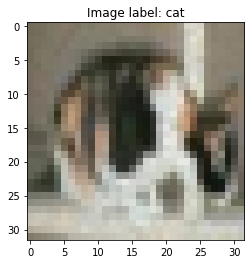

In [0]:
classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

test_normalize = test_transform.transforms[1]
mean = torch.tensor(test_normalize.mean, dtype=torch.float32)
std = torch.tensor(test_normalize.std, dtype=torch.float32)
inverse_transform = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())


def imshow(img_tensor):
    img_tensor = inverse_transform(torch.squeeze(img_tensor)).permute(1,2,0)
    plt.imshow(img_tensor)
    plt.show()


dataiter = iter(test_loader)
image, label = dataiter.next()
print('The shape of the target_image tensor is ' + str(image.shape))
plt.title('Image label: ' + str(classes[label.item()]))
imshow(image)

## The Basics of the HopSkipJump attack
* This is a powerful black-box attack that only requires final class prediction, and is an advanced version of the boundary attack.
In the untargeted setting (target=False) an adversarial is any image for which the predicted label is different from the label of the original image (since HopSkipJump has the classifier we can use it to get the class of the image). Then via various mathematical techniques we can generate an image that will classify into the randomly chosen target class.
* NOTE: The model (classifier) can still classify images into the wrong label. When this occurs we can have issues with the adversarial image actually matching the correct label which is something we do not want. This is why targeted attacks (where we essentially pick the class that we are trying to match using an init image) can perform better under certain circumstances. But for the most part this attack will serve its purpose.

In [0]:
classifier = PyTorchClassifier(model, criterion, optimizer, (3, 32, 32), 10, device_type='gpu')

The label for the image is a cat.
The model orginally classfied this image as a dog.
Adversarial image at step 0. L2 error 0.8701033 . Classified as a cat.


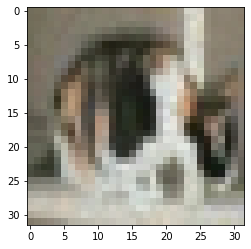

Adversarial image at step 50. L2 error 0.016307417 . Classified as a cat.


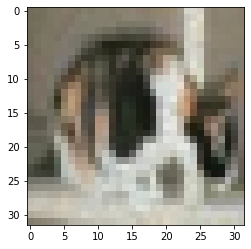

Adversarial image at step 100. L2 error 0.012010048 . Classified as a cat.


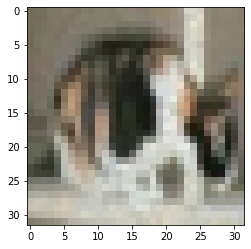

Adversarial image at step 150. L2 error 0.010807823 . Classified as a cat.


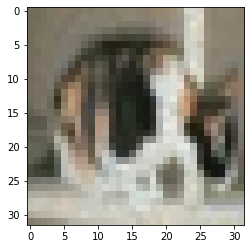

In [0]:
attack = HopSkipJump(classifier=classifier, targeted=False, max_iter=0, max_eval=1000, init_eval=10)
target_image = image.numpy()
print('The label for the image is a ' + classes[label.item()] + '.')
classified_label = np.argmax(classifier.predict(target_image))
print('The model orginally classfied this image as a ' + classes[classified_label] + '.')

iter_step = 10
x_adv = None
for i in range(20):
    x_adv = attack.generate(x=target_image, x_adv_init=x_adv, resume=True)
    if(i % 5 == 0):
      print("Adversarial image at step %d." % (i * iter_step), "L2 error", 
          np.linalg.norm(np.reshape(x_adv - target_image, [-1])),
          ". Classified as a %s." % classes[np.argmax(classifier.predict(x_adv))])
      imshow(torch.tensor(x_adv))
      plt.show(block=False)
    
    attack.max_iter = iter_step

In [10]:
# only test this on 100 images becuase it takes so long
attack = HopSkipJump(classifier=classifier, targeted=False, max_iter=50, max_eval=1000, init_eval=10)
correct = 0
total = 0
for images, labels in test_loader:
  target_image = images.numpy()
  x_adv = attack.generate(x=target_image, x_adv_init=None, resume=True)
  predicted = torch.tensor([np.argmax(classifier.predict(x_adv))])
  total += labels.size(0)
  correct += (predicted == labels).sum().item()
  if total > 100:
    break
    
print('Accuracy of the network against 5000 adversarial attack images: %d %%' % (
    100 * correct / total))

Accuracy of the network against 5000 adversarial attack images: 10 %
